In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32

## Set-up Starting Guesses

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
# make some elements zero
R[0,2] = 0
R[1,2] = 0
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.70249112, 0.29750888, 0.        ],
        [0.10528862, 0.89471138, 0.        ],
        [0.17208439, 0.18134107, 0.64657454]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
np.sum(T, axis=1)
T

array([[0.71282155, 0.28717845, 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.        , 0.89445942, 0.10554058],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1

In [5]:
infect = maxentep.contact_infection_func(0.1,infections_compartments)

## Set-up unbiased model

In [6]:
i = tf.keras.layers.Input((1,))
R_dist = maxentep.normal_mat_layer(i, R, name='R-unbiased')
T_dist =  maxentep.dirichlet_mat_layer(i, T, name='T-unbiased')
start_dist = maxentep.normal_mat_layer(i, start, clip_high=0.5, name='rho-unbiased')
unbiased_model = tf.keras.Model(inputs=i, outputs=[R_dist, T_dist, start_dist], name='unbiased-model')
unbiased_joint = unbiased_model(tf.constant([0.]))

## Create Trainable Model

In [7]:
i = tf.keras.layers.Input((1,))
R_dist = maxentep.normal_mat_layer(i, R, name='R')
T_dist =  maxentep.dirichlet_mat_layer(i, T, name='T')
start_dist = maxentep.normal_mat_layer(i, start, clip_high=0.5, name='rho')
model = tf.keras.Model(inputs=i, outputs=[R_dist, T_dist, start_dist], name='param-model')

## Set-up loglikelihood

In [8]:
def cross_entropy(y, rv_y):
    #print(tf.shape(w), tf.shape(y), rv_y)
    # reduce across other axis (summing independent variable log ps)
    logp = rv_y.log_prob(y + EPS)
    logp = tf.reduce_sum(tf.reshape(logp, (tf.shape(y)[0], -1)), axis=1)
    return -logp
model.compile(tf.optimizers.Adam(1e-2), loss=[cross_entropy, cross_entropy, cross_entropy])
model.summary()

Model: "param-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-hypers (TrainableInputLayer)  (1, 2, 3, 3)         18          input_2[0][0]                    
__________________________________________________________________________________________________
T-hypers (TrainableInputLayer)  (1, 4, 4)            16          input_2[0][0]                    
__________________________________________________________________________________________________
rho-hypers (TrainableInputLayer (1, 2, 3, 4)         24          input_2[0][0]                    
________________________________________________________________________________________

## Make some restraints

In [9]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Maxent Model

In [10]:
traj_model_layer = maxentep.MetapopLayer(100, infect)
traj_layer = maxentep.AddSusceptibleLayer()
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

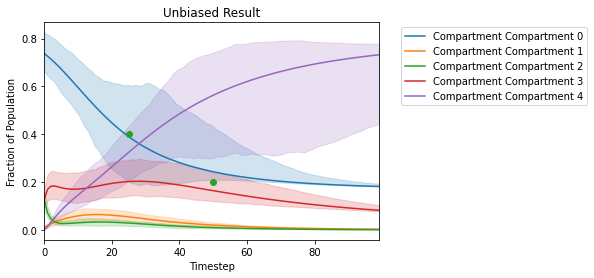

In [11]:
psample = [j.sample(param_batch_size) for j in unbiased_joint]
trajs = traj_layer(traj_model_layer(psample))
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

# have to rebuild, since we induced inputs by running above code (batch = dim 1)
traj_model_layer = maxentep.MetapopLayer(100, infect)
traj_layer = maxentep.AddSusceptibleLayer()

## Create Re-Weighter

In [12]:
def reweight(samples, joint):
    batch_dim = samples[0].shape[0]
    logit = tf.zeros((batch_dim,))
    for i,(uj,j) in enumerate(zip(unbiased_joint, joint)):
        # reduce across other axis (summing independent variable log ps)
        logitdiff = uj.log_prob(samples[i] + EPS) - j.log_prob(samples[i] + EPS)
        logit += tf.reduce_sum(tf.reshape(logitdiff, (batch_dim, -1)), axis=1)
    return tf.math.softmax(logit)

## Try to reweight without hyper-parameter tuning

In [13]:
me_loss = []
# sample and get batch
joint = model(tf.constant([0.]))
psample = [j.sample(param_batch_size) for j in joint]    
x = traj_model_layer(psample)
trajs = traj_layer(x)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

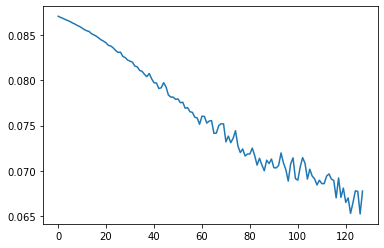

In [14]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

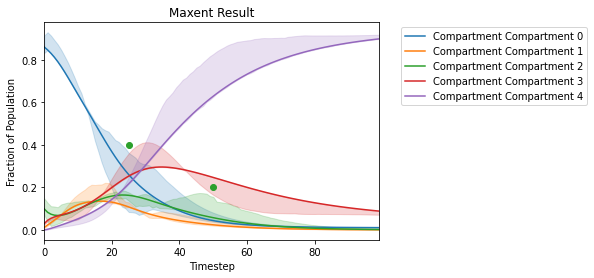

In [15]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [16]:
me_loss = []
p_loss = []

for i in tqdm.tqdm(range(32)):
    # sample and get batch
    joint = model(tf.constant([0.]))
    psample = [j.sample(param_batch_size) for j in joint]    
    x = traj_model_layer(psample)
    trajs = traj_layer(x)
    # get reweight logits
    rw = reweight(psample, joint)
    # get weights of trajectories
    h = maxent_model.fit(trajs, input_weights=rw, batch_size=maxent_batch_size, epochs=4, verbose=False)
    me_loss.extend(h.history['loss'])
    w = maxent_model.traj_weights
    # now use these to train hyper-parameters
    fake_x = tf.constant(param_batch_size * [0.])
    h = model.fit(fake_x, psample, batch_size=maxent_batch_size, 
                  sample_weight=w,verbose=False, epochs=128, use_multiprocessing=True)
    p_loss.extend(h.history['loss'])

100%|█████████████████████████████████████████████████████████████████████████| 32/32 [03:59<00:00,  7.48s/it]


## Now do final sample/weight with trained hyperparameters

In [24]:
# Now finish with tuned hyperparameters
# sample and get batch
joint = model(tf.constant([0.]))
psample = [j.sample(param_batch_size) for j in joint]    
x = traj_model_layer(psample)
trajs = traj_layer(x)
# get reweight logits
rw = reweight(psample, joint)
h = maxent_model.fit(trajs, input_weights=rw, batch_size=maxent_batch_size, epochs=256, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

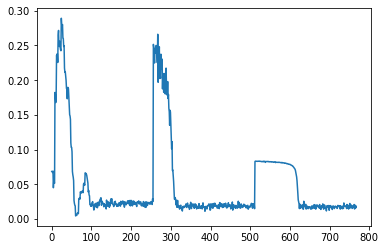

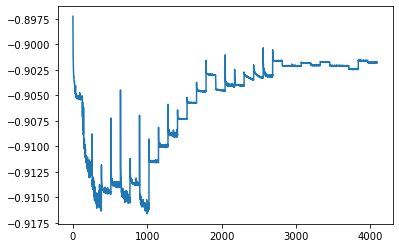

In [30]:
plt.plot(me_loss)
plt.show()
plt.plot(p_loss)

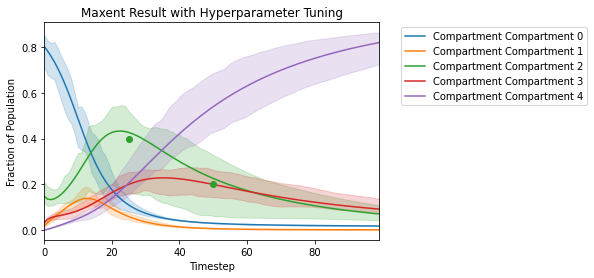

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

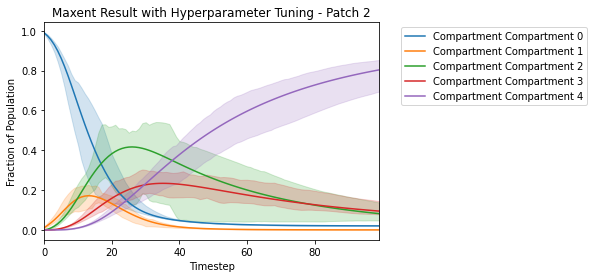

In [55]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Now compare with Directed regression

In [36]:
reg_model = maxentep.TrainableMetaModel(start, R, T, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [39]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(0.1))
reg_model.fit(epochs=6, verbose=True)

Epoch 1/6
100/100 [==============================] - 3s 30ms/step - loss: 0.1221 - output_2_loss: 0.1221
Epoch 2/6
100/100 [==============================] - 3s 30ms/step - loss: 0.0017 - output_2_loss: 0.0017
Epoch 3/6
100/100 [==============================] - 3s 30ms/step - loss: 4.7284e-04 - output_2_loss: 4.7284e-04
Epoch 4/6
100/100 [==============================] - 3s 30ms/step - loss: 3.7697e-04 - output_2_loss: 3.7697e-04: 0s - loss: 3.8902e-04 - output_2
Epoch 5/6
100/100 [==============================] - 3s 30ms/step - loss: 3.1454e-04 - output_2_loss: 3.1454e-04: 1s - loss: 3.2943e-04 - output_2_loss: 3 - ETA: 1s - loss: 3.2453e-04 - outpu
Epoch 6/6
100/100 [==============================] - 3s 30ms/step - loss: 2.6970e-04 - output_2_loss: 2.6970e-04


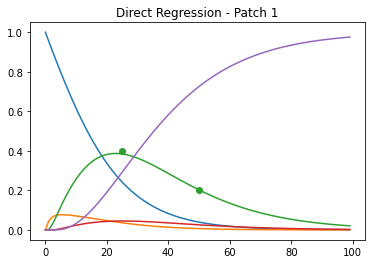

Text(0.5, 1.0, 'Direct Regression - Patch 2')

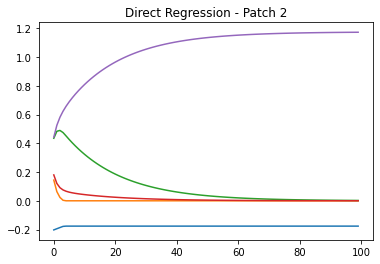

In [53]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')

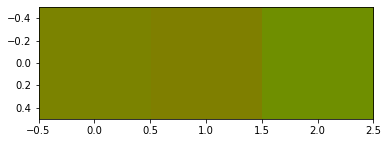

In [49]:
plt.imshow(reg_model.R, cmap='viridis')